In [1]:
%matplotlib inline

import os
import glob

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

import imageio
import scipy.ndimage as ndi

In [2]:
files = map(np.load, glob.glob("../export/data/gaze_data*.npz"))
# print files

In [3]:
sessions_info = [ d["session_info"].tolist() for d in files ]
# print sessions_info[0]

In [29]:
filename = sessions_info[0].get("mediaFile")
media = imageio.get_reader("../Dataset/Mahnob/data/media_24/53.avi".format(filename))
print dir(media)

['_BaseReaderWriter__closed', '_BaseReaderWriter_last_index', '__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__enter__', '__exit__', '__format__', '__getattribute__', '__hash__', '__init__', '__iter__', '__len__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_arg_input_params', '_arg_loop', '_arg_output_params', '_arg_pixelformat', '_arg_size', '_bytes_per_channel', '_checkClosed', '_close', '_depth', '_dtype', '_exe', '_filename', '_format', '_frame_catcher', '_get_cam_inputname', '_get_data', '_get_exe', '_get_length', '_get_meta_data', '_initialize', '_lastread', '_load_infos', '_meta', '_open', '_pix_fmt', '_pos', '_proc', '_read_frame', '_read_frame_data', '_reinitialize', '_request', '_skip_frames', '_stderr_catcher', '_terminate', 'close', 'closed', 'format', 'get_data', 'get_length', 'get_meta_data', 'get_next_data', 'iter_data', 'request', 'set_image_index']


In [30]:
media.get_meta_data()

{'duration': 105.08,
 'ffmpeg_version': u'3.4.4-0ubuntu0.18.04.1 built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)',
 'fps': 24.0,
 'nframes': 2522,
 'plugin': 'ffmpeg',
 'size': (320, 200),
 'source_size': (320, 200)}

In [5]:
sessions_id = [ int(s["sessionId"]) for s in sessions_info ]
print sessions_id

[10, 1206, 1588, 160, 1698, 1956, 2090, 2224, 2358, 2492, 2626, 2760, 2894, 3028, 3412, 3538, 3664, 3790, 426, 546, 814, 948]


In [6]:
# select which session to reject
rejected_sid = [426,814]
rejectd_index = [ sessions_id.index(i) for i in rejected_sid ]
#print rejectd_index

In [7]:
def grid_density_gaussian_filter(x0, y0, x1, y1, w, h, data, weight_fnc=None):

    '''
        this function will return an array of the size w*h representing the distribution of the coordinates data
        filtered by a 2D gaussian filter
    '''
    
    if weight_fnc is None:
        weight_fnc = lambda x: x

    if data.ndim == 2:
        data = np.append(data, np.ones([1, data.shape[0]]).T, axis=1)

    r = 8

    kx = (w - 1) / float(x1 - x0)
    ky = (h - 1) / float(y1 - y0)

    borderw = w / 2
    borderh = h / 2
    imgw = (w + 2 * borderw)
    imgh = (h + 2 * borderh)
    img = np.zeros((imgh,imgw))

    for x, y, d in data:

        ix = int((x - x0) * kx) + borderw
        iy = int((y - y0) * ky) + borderh

        if 0 <= ix < imgw and 0 <= iy < imgh:
            img[iy][ix] += weight_fnc(d)

    heatmap = ndi.gaussian_filter(img, (r,r))  ## gaussian convolution
    
    return heatmap[borderh:h+borderh, borderw:w+borderw]

In [8]:
# load gaze coordinates data

data = [ d["coordinates"] for d in files ]

# keep at most the miminum frome number available across all sessions
nframe = min(map(lambda x: np.size(x, axis=0), data))
print nframe

2522


In [9]:
# masked rejected index

coord_masked = np.ma.array(zip(*[d[:nframe] for d in data ]), mask=False)
coord_masked.mask[:,rejectd_index,:] = True

# print np.where(coord_masked.mask != False)

In [10]:
x = (0,1280/4)
y = (0,800/4)

frame = 11

# load image frame
image = media.get_data(frame)

# compute raw data frame heatmap
c_clean = coord_masked[frame][np.logical_not(coord_masked[frame].mask)].reshape(20, 2)
g_grid_mask = grid_density_gaussian_filter(x[0],y[0],x[1],y[1],x[1],y[1], c_clean)

In [13]:
# Compute heatmap for all frames

n_sub = len(sessions_id)-len(rejected_sid)
valid_frame_coord = coord_masked[np.logical_not(coord_masked.mask)].reshape([nframe, n_sub, 2])

heatmaps = []
for frame_coord in valid_frame_coord:
    heatmaps.append(grid_density_gaussian_filter(x[0],y[0],x[1],y[1],x[1],y[1], frame_coord).flatten())

heatmaps = np.vstack(heatmaps)

In [14]:
# normalize over all frames
norm_heatmap = ( heatmaps - heatmaps.min() ) / ( heatmaps.max() - heatmaps.min() )

In [32]:
# export heatmaps
data = {
    "media_filename" : filename,
    "media_metadata" : media.get_meta_data(),
    "sessions_id" : sessions_id,
    "heatmaps" : heatmaps,
}
np.savez_compressed("../export/data/gaze_heatmap_{}.npz".format(filename.split(".")[0]), **data)

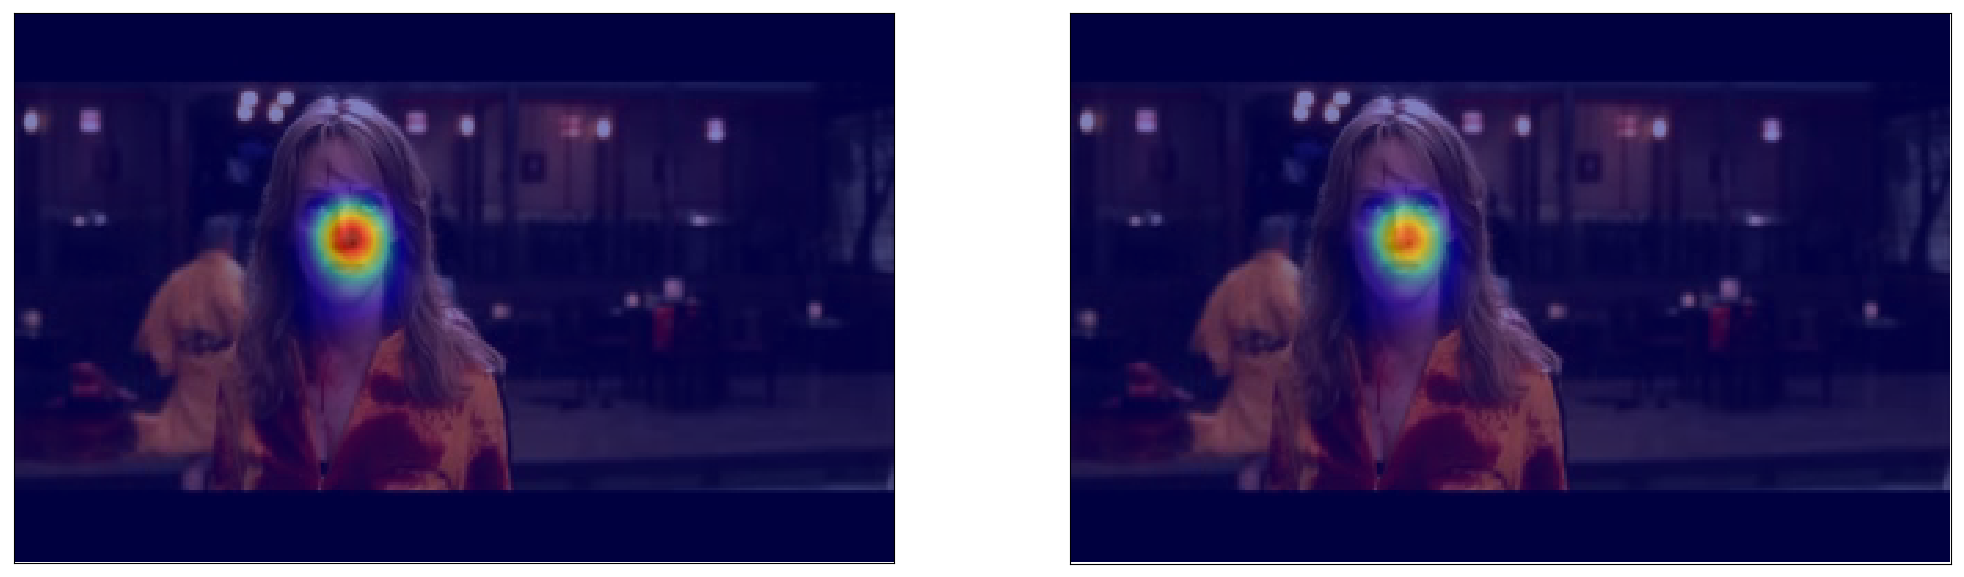

In [15]:
# Plot hetmaps over selected frame without data from rejected sessions.
#
# sx: raw coordinate heatmap 
# dx: raw coordinate heatmap normalized through all frames

dpi = 100

ncols=2
nrows=1

# determine the figure size in inches
figsize = (1280*ncols/dpi, 800*nrows/dpi)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)

extent = [0, 1280/4, 800/4, 0]

axes[0].axis(extent)
axes[0].set_aspect(8/5)
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].axis(extent)
axes[1].set_aspect(8/5)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

axes[0].imshow(image)
axes[0].imshow(g_grid_mask, alpha=.5, cmap='jet')

axes[1].imshow(image)
# here we normalize the plt from 0 to the max value among all frame to keep frame differences visible
axes[1].imshow(norm_heatmap[frame].reshape(200,320), cmap='jet', alpha=.5, vmin=0, vmax=norm_heatmap.max())

plt.show()